# Import des packages

In [34]:
import numpy as np
from mrmr import mrmr_regression
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.linear_model import LassoLars
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import random


from statsmodels.tsa.vector_ar.var_model import VAR

# Utilisation de l'algorithme de Feature Selection MRMR

## Préparation des données

In [3]:
data_path = 'data/VARSmall/returns'
data = pd.read_csv(data_path+'/'+'data_0.csv', header=0)

In [4]:
def prepare_data_vectorize(data, lags, target):

        lags = lags
        # used to vectorize several timesteps in a dimension 1 vector.
        y = data[target].iloc[lags:]
        indexes = y.index
        y = y.values
        window_X = [data.values[i:i+lags].reshape((-1,)) for i in range(len(data)-lags)]
        X = np.array(window_X)
        return X, y, indexes

In [ ]:
prepare_data_vectorize(data,10,'1')

In [5]:
def vector_mask_to_columns(mask, data):
        indexes = np.any(np.array(mask).reshape((-1,len(data.columns))), axis=0)
        selected = data.columns[indexes]
        selected=list(selected)
        return selected
      

In [6]:
def transform(r, data):
        """Transform the input data.

        This method uses the computed weight vector to produce a new
        dataset exhibiting only the `self.n_features` best-ranked features.

        ARGUMENTS
        -----
        data: The input data to transform

        RETURN VALUE
        -----
        A matrix with the same number of rows as `data` and at most
        `n_features` columns.
        """
        n_features = np.round(
            data.shape[1] * r.n_features
        ).astype(np.int16) if r.n_features < 1 else r.n_features
        feat_indices = np.flip(np.argsort(r.w_), 0)[0:n_features]

        return feat_indices

In [8]:
config = {
    'lags': 10,
    'num_features_to_select': 10
}

## Application de MRMR

In [40]:
def apply_mrmr(data, i,target):
        X, y, _ = prepare_data_vectorize(data, config['lags'],target)
        X_df = pd.DataFrame(X, columns=[f'lag_{i}' for i in range(1, X.shape[1] + 1)])
        num_features_to_select = config['num_features_to_select']
    
        selected_features_columns = mrmr_regression(X_df, y, i)
        vector_mask = [name in selected_features_columns for name in X_df.columns]
        selected_features_names=vector_mask_to_columns(vector_mask,data)

       
        return selected_features_names

In [ ]:
apply_mrmr(df,2)

# Open dataset and ground truth selectionne les targets possible de notre dataset

In [19]:
import pandas as pd
from collections import defaultdict
!pip install networkx
import networkx as nx


#! TODO: add support for lagged causes (ancestor, connected) computation with declared max lag.



# extractor functions
def node_to_tuple(node):
    lag, variable = node[1:].split(".")
    return (variable, lag)

def get_all_parents(graph, target):
    if "L0." + target in graph.nodes:
        l = list(graph.predecessors("L0." + target))
        return list(map(node_to_tuple, l))
    else:
        return list(graph.predecessors(target))

def get_all_ancestors(graph, target):
    if "L0." + target in graph.nodes:
        l = list(nx.ancestors(graph, "L0." + target))
        return list(map(node_to_tuple, l))
    else:
        return list(nx.ancestors(graph, target))

def get_all_connected(graph, target):
    if "L0." + target in graph.nodes:
        l = list(nx.node_connected_component(graph.to_undirected(), "L0." + target))
        return list(map(node_to_tuple, l))
    else:
        return list(nx.node_connected_component(graph.to_undirected(), target))

def standardize_df(df):
    return (df - df.mean(axis=0)) / df.std(axis=0)
       



def open_dataset_and_ground_truth(dataset_name: str,
                                  filename: str,
                                  cause_extraction="parents",
                                  rootdir=".",
                                  compute_window_causal_graph=False,
                                  window_size="max_direct"):
    """
    Open a file in a dataset family, where the ground truth is known:
    Params:
     - dataset_name: name of the dataset family
     - filename: name of the file containing the MTS instance
     (note: /data/<dataset_name>/<filename> is the complete path, with filename including the extension)
     - cause_extraction (optional): the method to compute the relevant variables
     - rootdir (optional): string indicating the root repository
     - computed_window_causal_graph (optional): bool set to True to compute window causal graph
     - window_size (optional): lag selection strategy for the window causal graph. Default is "max_direct" which takes the maximal lag of a cause.
    Returns:
     - df: the dataframe containing the MTS
     - var_names: the list of attribute names that can be forecasting target
     - causes_attributes_dict: dictionary associating each attribute to the list of its relevant predictors.
     - lagged_attributes_dict: dictionary associating each attribute to the list of its relevant predictors, containing lag information.
     - (optional) if compute_window_causal_graph is True, return the window causal graph as a networkx Digraph object
    """

    if dataset_name[:11] == "SynthNonlin":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df = df[df.columns[1:]]

    elif dataset_name[:4] == "fMRI":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]

    elif dataset_name[:10] == "FinanceCPT":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename, header=None)
        df.columns = [str(i) for i in df.columns]

    elif dataset_name[:18] == "TestCLIM_N-5_T-250":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename, header=None, sep=" ")
        df.columns = [str(i) for i in df.columns]
        
    elif dataset_name=="VARProcess/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="VARProcessNoCorr/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="VARLarge/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="VARSmall/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="VARVaried/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="dgp/piecewise_linear/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="dgp/monotonic/returns":
        df = pd.read_csv(rootdir + "data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="dgp/trigonometric/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="wikipediaMathEssencials/returns":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="Appliances":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="AusMacro":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df = df[df.columns[1:]]
        df.columns = [str(i) for i in df.columns]
    elif dataset_name=="AusMeteo":
        df = pd.read_csv(rootdir + "/data/" + dataset_name + "/" + filename)
        df.columns = [str(i) for i in df.columns]
    else:
        raise Exception("Dataset specified in config file is not implemented")

    var_names = list(df.columns)
    
    df = standardize_df(df)

    if dataset_name[:11] == "SynthNonlin":
        if dataset_name == "SynthNonlin/7ts2h":
            ground_truth_parents = defaultdict(list)
            ground_truth_lags = 10  # could be anything since we don't care about lags in this project
            ground_truth_parents["A"] = [("D", 1), ("A", 1)] #+ [("B", i) for i in range(1, ground_truth_lags + 1)]
            ground_truth_parents["D"] = [("H", 1), ("D", 1)] #+ [("E", i) for i in range(1, ground_truth_lags + 1)]
            ground_truth_parents["H"] = [("C", 1), ("H", 1)]
            ground_truth_parents["C"] = [("C", 1)]
            ground_truth_parents["F"] = [("C", 1), ("F", 1)]
            ground_truth_parents["B"] = [("F", 1), ("B", 1)] #+ [("A", i) for i in range(1, ground_truth_lags + 1)]
            ground_truth_parents["E"] = [("B", 1), ("E", 1)] #+ [("D", i) for i in range(1, ground_truth_lags + 1)]
        else:
            raise Exception("Dataset specified in argument is not implemented")

    elif dataset_name[:4] == "fMRI":
        index = filename[10:]
        index = index[:-4]
        g_truth_name = "fMRI_processed_by_Nauta/ground_truth/sim" + index + "_gt_processed.csv"

        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 0
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
            ground_truth_lags = max(ground_truth_lags, lag)

    elif dataset_name[:10] == "FinanceCPT":

        g_truth_name = "FinanceCPT/ground_truth/" + filename[:filename.find("_returns")] + ".csv"
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 0
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
            ground_truth_lags = max(ground_truth_lags, lag)

    elif dataset_name[:18] == "TestCLIM_N-5_T-250":
        g_truth_name = "TestCLIM_N-5_T-250/estimated_ground_truth/" + filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 2
        for cause, effect in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), 1))
            ground_truth_parents[str(effect)].append((str(cause), 2))
    
    elif dataset_name=="VARProcess/returns":
        g_truth_name = "VARProcess/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 5
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
            
    elif dataset_name=="VARProcessNoCorr/returns":
        g_truth_name = "VARProcessNoCorr/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 5
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
            
    elif dataset_name=="VARLarge/returns":
        g_truth_name = "VARLarge/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 5
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
    
    elif dataset_name=="VARSmall/returns":
        g_truth_name = "VARSmall/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 5
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
            
    elif dataset_name=="VARVaried/returns":
        g_truth_name = "VARVaried/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 5
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
            
    elif dataset_name=="dgp/piecewise_linear/returns":
        g_truth_name = "dgp/piecewise_linear/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 10
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
                        
    elif dataset_name=="dgp/monotonic/returns":
        g_truth_name = "dgp/monotonic/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 10
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
                        
    elif dataset_name=="dgp/trigonometric/returns":
        g_truth_name = "dgp/trigonometric/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        ground_truth_lags = 10
        for cause, effect, lag in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), lag))
            
    elif dataset_name=="wikipediaMathEssencials/returns":
        g_truth_name = "wikipediaMathEssencials/ground_truths/"+filename
        df_truth = pd.read_csv(rootdir + "data/" + g_truth_name, header=None, sep=",")
        ground_truth_parents = defaultdict(list)
        #there is no reason to assume particular lag information from this dataset.
        #therefore lag information in ground truth should not be taken into account.
        #a default value is put here
        ground_truth_lags = 10
        for cause, effect in df_truth.values:
            ground_truth_parents[str(effect)].append((str(cause), 1))
    
    elif dataset_name=="Appliances":
        var_names = ["Appliances"]
        return df, var_names, None, None

    elif dataset_name=="AusMacro":
        if filename == "data_0_original.csv":
            var_names = ["RGDP","CPI-ALL"]
        elif filename == "data_1_added_IBR.csv":
            var_names = ["IBR"]
        return df, var_names, None, None
    elif dataset_name=="AusMeteo":
        return df, var_names, None, None
            
    else:
        raise Exception("Dataset specified in argument is not implemented")

    ################
    #
    #   Creating the causal graphs
    #
    ################

    node_names = dict()
    for var in var_names:
        for lag in range(ground_truth_lags + 1):
            node_names[(var, lag)] = "L" + str(lag) + "." + str(var)

    # graph with only parents
    ground_truth_graph = nx.DiGraph()
    for key in node_names:
        ground_truth_graph.add_node(node_names[key])
    for key in ground_truth_parents:
        child_name = "L0." + str(key)
        for parent in ground_truth_parents[key]:
            parent_name = "L" + str(parent[1]) + "." + str(parent[0])
            ground_truth_graph.add_edge(parent_name, child_name)

    # summary graph (no lags)
    summary_graph = nx.DiGraph()
    summary_graph.add_nodes_from(var_names)
    maxlag = 0
    for cause, effect in ground_truth_graph.edges:
        lag = cause[1:cause.find(".")]
        maxlag = max([maxlag, int(lag)])
        cause = cause[cause.find(".") + 1:]
        effect = effect[effect.find(".") + 1:]
        if not summary_graph.has_edge(cause, effect):
            summary_graph.add_edge(cause, effect, lags=[lag])
        else:
            summary_graph[cause][effect]["lags"].append(lag)

    # window causal graph
    if compute_window_causal_graph:
        if window_size=="max_direct":
            nlags = maxlag
        window_graph = nx.DiGraph()
        node_names = []
        for var in df.columns:
            for lag in range(0, nlags):
                node_names.append("L" + str(lag) + "." + str(var))
        window_graph.add_nodes_from(node_names)
        for cause, effect in ground_truth_graph.edges:
            lag = int(cause[1:cause.find(".")])
            cause = cause[cause.find(".") + 1:]
            effect = effect[effect.find(".") + 1:]
            for L in range(lag, nlags):
                window_graph.add_edge("L" + str(L) + "." + cause, "L" + str(L - lag) + "." + effect)
        #window_graph_pos = dict([(node,
        #                          (1 - int(node[1:node.find(".")]) / data_config['pastPointsToForecast'],
        #                           1 - VAR_NAMES.index(node[node.find(".") + 1:]) / len(VAR_NAMES)))
        #                         for node in window_graph.nodes()])
    
    
    # get causes variables    
    
    causes_attributes_dict = defaultdict(list)

    for target_name in var_names:
        if cause_extraction == "parents":
            causes_attributes = get_all_parents(summary_graph, target_name)
        elif cause_extraction == "ancestors":
            causes_attributes = get_all_ancestors(summary_graph, target_name)
        elif cause_extraction == "connected":
            causes_attributes = get_all_connected(summary_graph, target_name)
        else:
            raise Exception("causeExtraction method specified in config file is not implemented")

        causes_attributes_dict[target_name] = list(map(str,causes_attributes))
        
    # get lagged causes (variables, lag)
    # due to the difficulty of specifying a maximum lag, only parent set is returned
    
    lagged_causes_attributes_dict = defaultdict(list)
    for target_name in var_names:
        lagged_causes_attributes = get_all_parents(ground_truth_graph, target_name)

        lagged_causes_attributes_dict[target_name] = lagged_causes_attributes
    
    if compute_window_causal_graph:
        return df, var_names, causes_attributes_dict, lagged_causes_attributes_dict, window_graph
        
    return df, var_names, causes_attributes_dict, lagged_causes_attributes_dict

Defaulting to user installation because normal site-packages is not writeable


In [20]:
dataset_name = "VARSmall/returns"
filename ='data_0.csv'

df, var_names, causes_attributes_dict, lagged_causes_attributes_dict = open_dataset_and_ground_truth(dataset_name, filename, rootdir="./")
print(var_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


# Mesure des performances de l'algorithme sur différents dataset

In [21]:
def compute_stats_selected(totalcolumns, selected, causes, lagged_causes, selection_mode="variable"):
    """
    Compute metrics about the selected set versus the ground truth set.
    Params:
        totalcolumns: int, total number of columns in the dataset
        selected: list of str if selection_mode is "variable", the list of selected columns by the feature selection algorithm
                  list of (str, int) if selection mode is "variable, lag", the list of selected features by the FS algorithm
        causes: list of str, the list of ground truth relevant columns (without lag information)
        lagged_causes: list of str, the list of ground truth lagged causes. This argument is ignored if selection_mode is "variable".
        selection_mode (optional): str, "variable, lag" if the selected set contains lagged information, "variable" otherwise.
    Returns:
        row: dict, contains the different metrics indexed by name, and the associated value.
    """
    row = {"FS_size":len(selected)}
    if causes is not None:  # if none, the data has no ground truth graph. So no stats to compute.
        if selection_mode == "variable":
            sPred = set(selected)
            sTrue = set(causes)
        elif selection_mode == "variable, lag":
            # assume output is of form (variable, lag)
            sPred = set(map(str,selected))
            sTrue = set(map(str,lagged_causes))
        sTP = sTrue & sPred
        recall = len(sTP)/len(sTrue) if len(sTrue)>0 else 0
        precision = len(sTP)/len(sPred) if len(sPred)>0 else 0
        row = {**row,
               "precision": precision,
               "recall": recall,
               "TP": len(sTP),
               "FP": len(sPred) - len(sTP),
               "FN": len(sTrue) - len(sTP),
               "TN": totalcolumns + len(sTP) - len(sPred) - len(sTrue),
               "f1-score": 2*precision*recall/(precision+recall) if precision+recall>0  else np.nan}
    return row  

In [63]:
data

,0,1,2,3,4,5,6,7,8,9
0,1.908825,2.596074,1.034724,-1.135257,0.065906,0.690409,0.299535,2.302776,9.716769,1.561069
1,-0.879137,-4.424467,1.137162,0.087949,0.102395,-0.400663,-1.198871,-0.984148,-9.917783,-1.242453
2,2.587432,3.656558,1.415186,0.583370,-1.915475,2.050390,-0.768140,2.493813,9.072561,3.836841
3,-2.231217,-3.539309,1.297854,0.665354,0.937309,0.245306,0.029198,-1.995012,-8.946506,-2.439790
4,0.574858,2.314810,1.466120,-0.557164,0.605155,2.716257,-0.139845,-0.359748,10.522100,2.828474
...,...,...,...,...,...,...,...,...,...,...
3495,-2.024658,1.516321,-0.704286,3.091474,2.312899,-1.841740,1.355696,0.587832,0.341100,0.601310
3496,-1.949521,1.807881,-1.632682,-2.187092,-1.139934,-0.829941,-0.792240,-0.340167,0.301370,-0.920667
3497,0.506805,0.413058,-0.834793,1.636813,-0.583988,-0.969869,-0.583781,-0.309219,2.055202,0.256696
3498,-1.321734,-0.145013,0.422454,0.768626,0.225386,2.520439,2.534386,-1.053802,-0.367389,-0.932409


In [22]:
target='2'
config['num_features_to_select'] = 50
selected=apply_mrmr(df,10,target)
ground_truth_causes = causes_attributes_dict[target]
total_columns=len(df.columns)
stats = compute_stats_selected(total_columns, selected, ground_truth_causes, None, selection_mode="variable")
print(stats)

100%|██████████| 10/10 [00:02<00:00,  3.52it/s]

{'FS_size': 8, 'precision': 0.75, 'recall': 1.0, 'TP': 6, 'FP': 2, 'FN': 0, 'TN': 2, 'f1-score': 0.8571428571428571}


In [111]:
causes_attributes_dict[target]

['2', '3', '4', '5', '7', '9']

In [112]:
selected

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Résultats pour VARSmall

In [23]:
data_path = 'data/VARSmall/returns'
data = pd.read_csv(data_path+'/'+'data_0.csv', header=0)


dataset_name = "VARSmall/returns"
filename ='data_0.csv'

df, var_names, causes_attributes_dict, lagged_causes_attributes_dict = open_dataset_and_ground_truth(dataset_name, filename, rootdir="./")
print(var_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [71]:
target='5'
config['num_features_to_select'] = 50
selected=apply_mrmr(df,2,target)
ground_truth_causes = causes_attributes_dict[target]
total_columns=len(df.columns)
stats = compute_stats_selected(total_columns, selected, ground_truth_causes, None, selection_mode="variable")
print(stats)
print (selected)

KeyError: '5'

In [24]:
Y,X,Z=[],[],[]
target='2'
config['num_features_to_select'] = 10
n_feature=0 
for i in range(0,10):
    #target=random.choice(var_names)
    selected=apply_mrmr(df,n_feature,target)
    dict_metrics=compute_stats_selected(total_columns,selected,ground_truth_causes,None,selection_mode="variable")
    Y.append(dict_metrics['precision'])
    X.append(n_feature)
    Z.append(dict_metrics['recall'])
    print(X)
    print(Y)
    print(Z)
    n_feature+=1


0it [00:00, ?it/s]


[0]
[0]
[0.0]


100%|██████████| 1/1 [00:00<00:00, 445.35it/s]


[0, 1]
[0, 1.0]
[0.0, 0.16666666666666666]


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

[0, 1, 2]
[0, 1.0, 0.5]
[0.0, 0.16666666666666666, 0.16666666666666666]



100%|██████████| 3/3 [00:00<00:00,  4.20it/s]

[0, 1, 2, 3]
[0, 1.0, 0.5, 0.6666666666666666]
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333]



100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

[0, 1, 2, 3, 4]
[0, 1.0, 0.5, 0.6666666666666666, 0.75]
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5]



100%|██████████| 5/5 [00:01<00:00,  3.81it/s]

[0, 1, 2, 3, 4, 5]
[0, 1.0, 0.5, 0.6666666666666666, 0.75, 0.8]
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666]



100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

[0, 1, 2, 3, 4, 5, 6]
[0, 1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334]
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334]



100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8333333333333334]
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334]



100%|██████████| 8/8 [00:02<00:00,  3.84it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8333333333333334, 0.7142857142857143]
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334]



100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1.0, 0.5, 0.6666666666666666, 0.75, 0.8, 0.8333333333333334, 0.8333333333333334, 0.7142857142857143, 0.75]
[0.0, 0.16666666666666666, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666, 0.8333333333333334, 0.8333333333333334, 0.8333333333333334, 1.0]


Pour la target "2"


Text(0.5, 1.0, 'Evolution of precision & recall based on number of features for dataset VARSmall ')

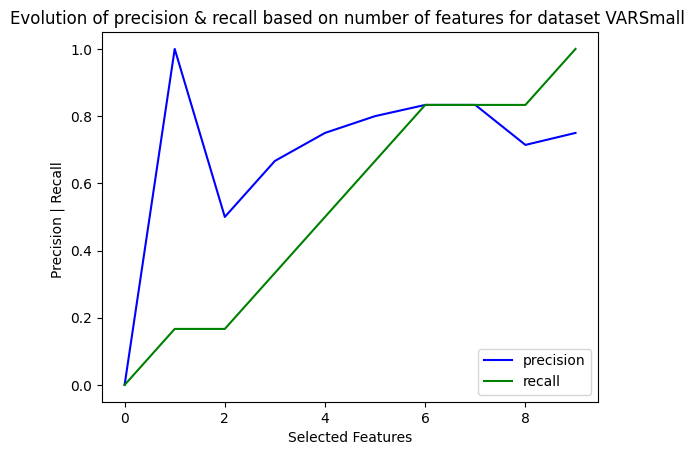

In [25]:
print(f'Pour la target "{target}"')
plt.plot(X,Y,'b',label='precision')
plt.plot(X,Z,'g',label='recall')
plt.legend()
plt.xlabel('Selected Features')
plt.ylabel('Precision | Recall ')
plt.title('Evolution of precision & recall based on number of features for dataset VARSmall ')

# Résultats pour dgp monotonic

In [66]:
data_path = 'data/dgp/monotonic/returns'
data = pd.read_csv(data_path+'/'+'data_0.csv', header=0)


dataset_name = "dgp/monotonic/returns"
filename ='data_0.csv'

df, var_names, causes_attributes_dict, lagged_causes_attributes_dict = open_dataset_and_ground_truth(dataset_name, filename, rootdir="./")
print(var_names)

['X1', 'X10', 'X100', 'X1000', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X11', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X12', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X13', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X14', 'X140', 'X141', 'X142', 'X143', 'X144', 'X145', 'X146', 'X147', 'X148', 'X149', 'X15', 'X150', 'X151', 'X152', 'X153', 'X154', 'X155', 'X156', 'X157', 'X158', 'X159', 'X16', 'X160', 'X161', 'X162', 'X163', 'X164', 'X165', 'X166', 'X167', 'X168', 'X169', 'X17', 'X170', 'X171', 'X172', 'X173', 'X174', 'X175', 'X176', 'X177', 'X178', 'X179', 'X18', 'X180', 'X181', 'X182', 'X183', 'X184', 'X185', 'X186', 'X187', 'X188', 'X189', 'X19', 'X190', 'X191', 'X192', 'X193', 'X194', 'X195', 'X196', 'X197', 'X198', 'X199', 'X2', 'X20', 'X200', 'X201', 'X202', 'X203', 'X204', 'X205', 'X206', 'X207', 'X208', 'X209', 'X21', 'X210', 'X211'

In [68]:
target='X3'
config['num_features_to_select'] = 10
selected=apply_mrmr(df,10,target)
ground_truth_causes = causes_attributes_dict[target]
total_columns=len(df.columns)
stats = compute_stats_selected(total_columns, selected, ground_truth_causes, None, selection_mode="variable")
print(stats)
print(selected)

100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

{'FS_size': 10, 'precision': 0.0, 'recall': 0.0, 'TP': 0, 'FP': 10, 'FN': 2, 'TN': 988, 'f1-score': nan}
['X250', 'X426', 'X472', 'X676', 'X716', 'X794', 'X817', 'X892', 'X962', 'X981']


In [46]:
Y,X,Z=[],[],[]
target='X3'
config['num_features_to_select'] = 10
n_feature=0 
for i in range(0,10):
    target=random.choice(var_names)
    selected=apply_mrmr(df,n_feature,target)
    dict_metrics=compute_stats_selected(total_columns,selected,ground_truth_causes,None,selection_mode="variable")
    Y.append(dict_metrics['precision'])
    X.append(n_feature)
    Z.append(dict_metrics['recall'])
    print(X)
    print(Y)
    print(Z)
    n_feature+=1



0it [00:00, ?it/s]


[0]
[0]
[0.0]


100%|██████████| 1/1 [00:00<00:00, 511.25it/s]


[0, 1]
[0, 0.0]
[0.0, 0.0]


100%|██████████| 2/2 [00:00<00:00,  7.99it/s]

[0, 1, 2]
[0, 0.0, 0.5]
[0.0, 0.0, 1.0]



100%|██████████| 3/3 [00:00<00:00,  4.92it/s]

[0, 1, 2, 3]
[0, 0.0, 0.5, 0.3333333333333333]
[0.0, 0.0, 1.0, 1.0]



100%|██████████| 4/4 [00:00<00:00,  4.11it/s]

[0, 1, 2, 3, 4]
[0, 0.0, 0.5, 0.3333333333333333, 0.25]
[0.0, 0.0, 1.0, 1.0, 1.0]



100%|██████████| 5/5 [00:01<00:00,  4.35it/s]

[0, 1, 2, 3, 4, 5]
[0, 0.0, 0.5, 0.3333333333333333, 0.25, 0.25]
[0.0, 0.0, 1.0, 1.0, 1.0, 1.0]



100%|██████████| 6/6 [00:01<00:00,  4.94it/s]

[0, 1, 2, 3, 4, 5, 6]
[0, 0.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25]
[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]



100%|██████████| 7/7 [00:01<00:00,  4.84it/s]

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 0.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25]
[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



100%|██████████| 8/8 [00:01<00:00,  4.51it/s]


[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 0.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25, 0.2]
[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 9/9 [00:02<00:00,  4.27it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 0.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25, 0.2, 0.2]
[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Pour la target "X3"


Text(0.5, 1.0, 'Evolution of precision &  recall based on number of features for dataset dgp monotonic ')

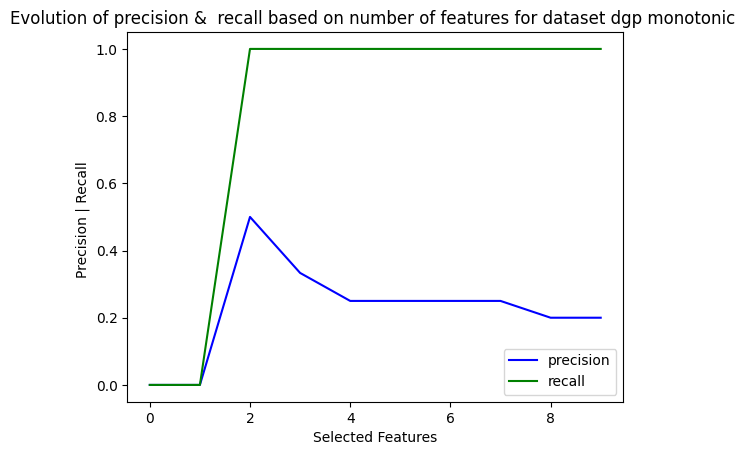

In [72]:
print(f'Pour la target "X3"')
plt.plot(X,Y,'b',label='precision')
plt.plot(X,Z,'g',label='recall')
plt.legend()
plt.xlabel('Selected Features')
plt.ylabel('Precision | Recall ')
plt.title('Evolution of precision &  recall based on number of features for dataset dgp monotonic ')

# Résultats pour fmRI

In [69]:
data_path = 'data/fMRI_processed_by_Nauta/returns/original'
data = pd.read_csv(data_path+'/'+'timeseries1.csv', header=0)


dataset_name = "fMRI_processed_by_Nauta/returns/original"
filename ='timeseries1.csv'

df, var_names, causes_attributes_dict, lagged_causes_attributes_dict = open_dataset_and_ground_truth(dataset_name, filename, rootdir="./")
print(var_names)

target='4'
config['num_features_to_select'] = 10
selected=apply_mrmr(df,5,target)
ground_truth_causes = causes_attributes_dict[target]
total_columns=len(df.columns)
stats = compute_stats_selected(total_columns, selected, ground_truth_causes, None, selection_mode="variable")
print(stats)
print(selected)

['0', '1', '2', '3', '4']


100%|██████████| 5/5 [00:00<00:00,  5.16it/s]

{'FS_size': 4, 'precision': 0.25, 'recall': 1.0, 'TP': 1, 'FP': 3, 'FN': 0, 'TN': 1, 'f1-score': 0.4}
['0', '1', '3', '4']


In [41]:
Y,X,Z=[],[],[]
target='4'
config['num_features_to_select'] = 10
n_feature=0 
for i in range(0,10):
    #target=random.choice(var_names)
    selected=apply_mrmr(df,n_feature,target)
    dict_metrics=compute_stats_selected(total_columns,selected,ground_truth_causes,None,selection_mode="variable")
    Y.append(dict_metrics['precision'])
    X.append(n_feature)
    Z.append(dict_metrics['recall'])
    print(X)
    print(Y)
    print(Z)
    n_feature+=1

0it [00:00, ?it/s]


[0]
[0]
[0.0]


100%|██████████| 1/1 [00:00<00:00, 455.75it/s]


[0, 1]
[0, 1.0]
[0.0, 1.0]


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

[0, 1, 2]
[0, 1.0, 0.5]
[0.0, 1.0, 1.0]



100%|██████████| 3/3 [00:00<00:00,  4.30it/s]

[0, 1, 2, 3]
[0, 1.0, 0.5, 0.3333333333333333]
[0.0, 1.0, 1.0, 1.0]



100%|██████████| 4/4 [00:00<00:00,  4.87it/s]

[0, 1, 2, 3, 4]
[0, 1.0, 0.5, 0.3333333333333333, 0.25]
[0.0, 1.0, 1.0, 1.0, 1.0]



100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


[0, 1, 2, 3, 4, 5]
[0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.25]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0]


100%|██████████| 6/6 [00:01<00:00,  4.30it/s]

[0, 1, 2, 3, 4, 5, 6]
[0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



100%|██████████| 7/7 [00:01<00:00,  4.41it/s]

[0, 1, 2, 3, 4, 5, 6, 7]
[0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



100%|██████████| 8/8 [00:01<00:00,  4.12it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25, 0.25]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1.0, 0.5, 0.3333333333333333, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2]
[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Pour la target "4"


Text(0.5, 1.0, 'Evolution of precision &  recall based on number of features for dataset fmRI ')

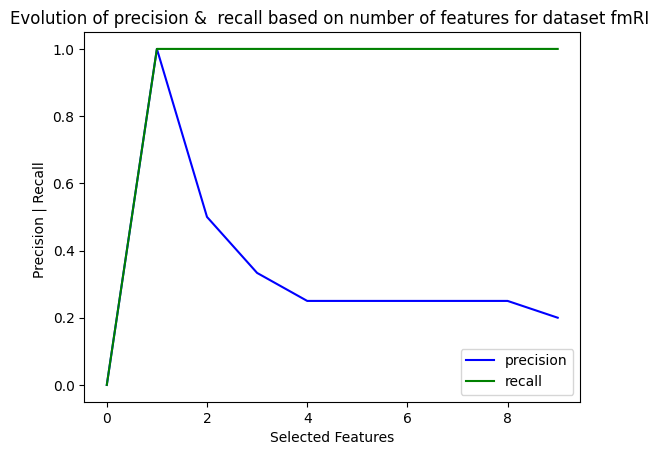

In [45]:
print(f'Pour la target "4"')
plt.plot(X,Y,'b',label='precision')
plt.plot(X,Z,'g',label='recall')
plt.legend()
plt.xlabel('Selected Features')
plt.ylabel('Precision | Recall ')
plt.title('Evolution of precision &  recall based on number of features for dataset fmRI ')

In [89]:
import os
import pandas as pd
from graphviz import Digraph

def plot_causal_graph_from_csv(data_folder="returns", ground_truth_folder="ground_truth"):
    """
    Trace le graphe causal à partir de fichiers CSV dans les dossiers spécifiés.

    Parameters:
    - data_folder: Nom du dossier contenant les données (par défaut: "returns").
    - ground_truth_folder: Nom du dossier contenant les variables d'intérêt (par défaut: "ground_truth").

    Returns:
    - Aucun (affiche le graphe causal).
    """
    # Ajouter le répertoire Graphviz au PATH
    %env PATH=/usr/bin/graphviz/bin:$PATH

    # Créer un graphe dirigé
    dot = Digraph(comment='Causal Graph')

    # Charger les données à partir des fichiers CSV dans le dossier "returns"
    returns_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
    for file in returns_files:
        file_path = os.path.join(data_folder, file)
        data = pd.read_csv(file_path)

        # Ajouter les nœuds au graphe
        for column in data.columns:
            dot.node(column)

        # Ajouter les arêtes (liens causaux) en supposant une relation linéaire entre les colonnes
        for i in range(len(data.columns) - 1):
            dot.edge(data.columns[i], data.columns[i + 1])

    # Charger les variables d'intérêt à partir des fichiers CSV dans le dossier "ground_truth"
    ground_truth_files = [f for f in os.listdir(ground_truth_folder) if f.endswith('.csv')]
    for file in ground_truth_files:
        file_path = os.path.join(ground_truth_folder, file)
        ground_truth = pd.read_csv(file_path)

        # Ajouter les nœuds au graphe
        for column in ground_truth.columns:
            dot.node(column, color='red')  # Mettre en surbrillance les variables d'intérêt en rouge

    # Afficher le graphe
    dot.render('causal_graph', format='png', cleanup=True)
    dot.view()

# Exemple d'utilisation
plot_causal_graph_from_csv()


env: PATH=/usr/bin/graphviz/bin:$PATH


FileNotFoundError: [Errno 2] No such file or directory: 'returns'

In [88]:
export PATH="/usr/bin/graphviz/bin:$PATH"


SyntaxError: invalid syntax (396300048.py, line 1)